
>>> INITIALIZING SYSTEM FOR: INTC <<<
Note: Single Stock 'INTC' Detected.
 -> Enabling LONG_ONLY Mode (No Shorting).
 -> Disabling Volatility Targeting to prevent dampening returns.

=== 1. TRAINING SPECIALIST AGENTS ===
Fetching data for: ['^VIX', 'SHY', 'INTC'] (2015-01-01 to 2023-12-31)
>> Training Trend Agent...


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:93: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)


>> Training Mean Rev Agent...
>> Training Crisis Agent...
Fetching data for: ['^VIX', 'SHY', 'INTC'] (2007-08-01 to 2009-06-01)
Fetching data for: ['^VIX', 'SHY', 'INTC'] (2018-10-01 to 2019-01-01)
Fetching data for: ['^VIX', 'SHY', 'INTC'] (2020-01-01 to 2020-05-01)
Fetching data for: ['^VIX', 'SHY', 'INTC'] (2022-01-01 to 2022-12-31)


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:93: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:93: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000

=== TRAINING COMPLETE ===

=== 2. RUNNING ENSEMBLE BACKTEST (2017-09-01 to 2021-12-01) ===
Fetching Warmup Data from: 2016-09-01
Fetching data for: ['^VIX', 'SHY', 'INTC'] (2016-09-01 to 2021-12-01)
Date         | Regime     | Active Agent | Vol%   | RealVol  | Raw Act  | Scale Act  | Balance   
-------------------------------------------------------------------------------------------------------------------
2017-09-14   | TREND      | trend      | 0.00   | 0.14     | 0.21     | 1.00       | 100247    
2017-09-28   | TREND      | trend      | 0.00   | 0.12     | 0.25     | 1.00       | 103957    
2017-10-12   | TREND      | trend      | 0.20   | 0.12     | 0.18     | 1.00       | 107694    
2017-10-26   | TREND      | trend      | 0.33   | 0.12     | 0.18     | 1.00       | 113630    
2017-11-09   | TREND      | trend      | 0.99   | 0.29     | 0.32     | 1.00       | 127987    
2017-11-24   | TREND      | trend      | 1.00   | 0.33     | 0.45     | 1.00       | 123702    
2017-12-08 

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=start, end=end, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_74102/2006370944.py:93: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)


2020-12-16   | TREND      | trend      | 0.31   | 0.24     | 0.57     | 0.00       | 174042    
2020-12-31   | TREND      | trend      | 0.51   | 0.37     | 0.58     | 0.00       | 180884    
2021-01-15   | TREND      | trend      | 0.72   | 0.45     | 0.54     | 1.00       | 194926    
2021-02-01   | TREND      | trend      | 0.78   | 0.58     | 0.62     | 1.00       | 191913    
2021-02-16   | TREND      | trend      | 0.71   | 0.52     | 0.61     | 1.00       | 212764    
2021-03-02   | TREND      | trend      | 0.42   | 0.34     | 0.55     | 1.00       | 208575    
2021-03-16   | CHOP       | mean_rev   | 0.55   | 0.41     | 0.65     | 1.00       | 220631    
2021-03-30   | TREND      | trend      | 0.55   | 0.41     | 0.77     | 1.00       | 217191    
2021-04-14   | TREND      | trend      | 0.47   | 0.36     | 0.79     | 1.00       | 218622    
2021-04-28   | TREND      | trend      | 0.39   | 0.32     | 0.84     | 1.00       | 196245    
2021-05-12   | TREND      | trend      |

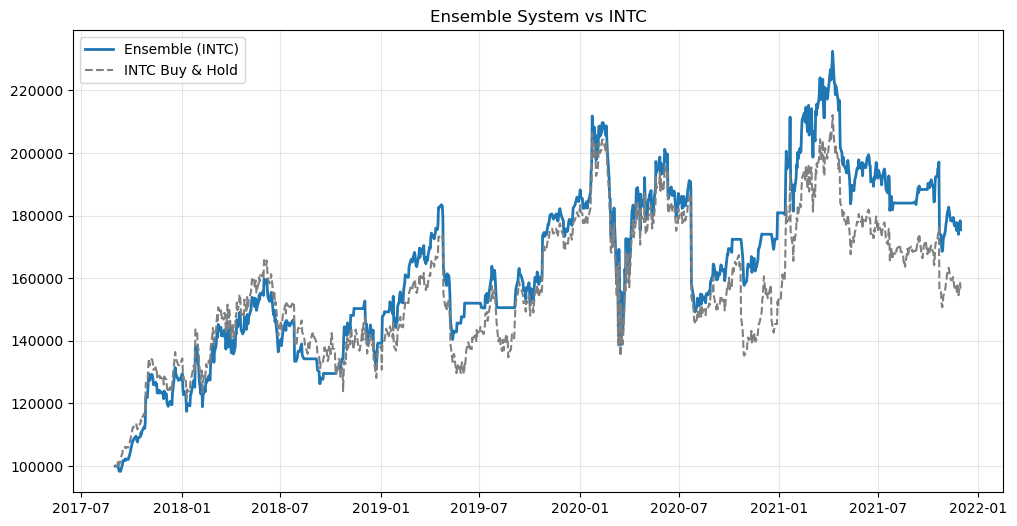

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt

# ==========================================
# 1. GLOBAL CONFIGURATION
# ==========================================
CONFIG = {
    # Assets
    "TICKERS": ["SPY", "IWM", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-01-01",
    
    # Crisis Training Periods
    "CRISIS_PERIODS": [
        ("2007-08-01", "2009-06-01"), # GFC
        ("2018-10-01", "2019-01-01"), # Volmageddon
        ("2020-01-01", "2020-05-01"), # COVID
        ("2022-01-01", "2022-12-31"), # Bear
    ],
    
    # Feature Engineering
    "WINDOW_SIZE": 60, # Increased from 20 to 60 to reduce noise for single stocks
    "BB_STD": 2.0,
    
    # Agent Parameters
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 100000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.0005,
    "BORROW_RATE": 0.0002, 
    
    # --- RISK MANAGEMENT SETTINGS ---
    "ACTION_SCALER": 5.0,
    "MAX_LEVERAGE": 1.0, 
    
    # Volatility Targeting
    "USE_VOL_TARGETING": True,
    "TARGET_VOL": 0.20, 
    
    # SMA Trend Filter
    "SMA_TREND_FILTER": True,
    
    # NEW: Long Only Constraint (Auto-enabled for single stocks)
    "LONG_ONLY": False 
}

# ==========================================
# 2. DATA PROCESSOR (MULTI-REGIME)
# ==========================================
class DataProcessor:
    def __init__(self, tickers):
        # Deduplicate and ensure list
        self.tickers = list(set(tickers))
        
    def download(self, start, end):
        try:
            # Add target asset to download list if missing (Safety check)
            if CONFIG['TARGET_ASSET'] not in self.tickers:
                self.tickers.append(CONFIG['TARGET_ASSET'])
                
            print(f"Fetching data for: {self.tickers} ({start} to {end})")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            # Robust Column Extraction
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: 
                    data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: 
                    data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: 
                    data = data.xs('Close', level=1, axis=1)
            
            # If only one ticker was requested/returned
            if isinstance(data, pd.Series): 
                data = data.to_frame()
                if CONFIG['TARGET_ASSET'] not in data.columns:
                    data.columns = [CONFIG['TARGET_ASSET']]
            
            # Need High/Low for ADX (Using Target Asset)
            ohlc = yf.download(CONFIG['TARGET_ASSET'], start=start, end=end, progress=False)
            return data, ohlc
        except Exception as e:
            print(f"Data Download Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def add_features(self, df, ohlc, target=None):
        if target is None:
            target = CONFIG['TARGET_ASSET']
            
        if df.empty: return pd.DataFrame()

        # VALIDATION
        if target not in df.columns:
            if len(df.columns) == 1:
                target = df.columns[0]
            else:
                return pd.DataFrame()
            
        df = df.copy()
        
        # --- 1. Base Returns ---
        df['returns'] = df[target].pct_change()
        
        # --- 2. Trend Indicators (ADX) ---
        df['tr'] = np.maximum(ohlc['High'] - ohlc['Low'], 
                   np.maximum(abs(ohlc['High'] - ohlc['Close'].shift(1)), 
                              abs(ohlc['Low'] - ohlc['Close'].shift(1))))
        df['dm_plus'] = np.where((ohlc['High'] - ohlc['High'].shift(1)) > (ohlc['Low'].shift(1) - ohlc['Low']), 
                                 np.maximum(ohlc['High'] - ohlc['High'].shift(1), 0), 0)
        df['dm_minus'] = np.where((ohlc['Low'].shift(1) - ohlc['Low']) > (ohlc['High'] - ohlc['High'].shift(1)), 
                                  np.maximum(ohlc['Low'].shift(1) - ohlc['Low'], 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        
        df['di_plus'] = 100 * (df['dp_s'] / df['tr_s'])
        df['di_minus'] = 100 * (df['dm_s'] / df['tr_s'])
        df['dx'] = 100 * abs(df['di_plus'] - df['di_minus']) / (df['di_plus'] + df['di_minus'])
        df['adx'] = df['dx'].rolling(window).mean()
        
        # --- 3. Mean Reversion Indicators ---
        sma = df[target].rolling(20).mean()
        std = df[target].rolling(20).std()
        df['bb_width'] = (std * 2 * 2) / sma
        df['pct_b'] = (df[target] - (sma - 2*std)) / (4*std)
        # Safe RSI
        up = df['returns'].clip(lower=0)
        down = -1 * df['returns'].clip(upper=0)
        ma_up = up.rolling(window).mean()
        ma_down = down.rolling(window).mean()
        rs = ma_up / (ma_down + 1e-9)
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # --- 4. Crisis Indicators ---
        if '^VIX' in df.columns:
            df['vix_norm'] = (df['^VIX'] - 15) / 40
        else:
            df['vix_norm'] = 0
            
        sma200 = df[target].rolling(200).mean()
        df['dist_sma200'] = (df[target] - sma200) / sma200
        
        # --- 5. Volatility Percentile & Raw Vol ---
        # Annualized Volatility (20 day rolling)
        df['realized_vol_20d'] = df['returns'].rolling(20).std() * np.sqrt(252)
        # Rolling percentile of volatility (0 to 1) over last year
        df['vol_percentile'] = df['realized_vol_20d'].rolling(252).rank(pct=True)
        
        df = df.fillna(0)
        return df

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        if df.empty: return pd.DataFrame()
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in CONFIG['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            if not d.empty:
                dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# ==========================================
# 3. UNIFIED AGENT ENVIRONMENT
# ==========================================
class TradingEnv(gym.Env):
    def __init__(self, df, mode='trend'):
        super(TradingEnv, self).__init__()
        self.df = df
        self.mode = mode 
        self.n_features = df.shape[1]
        self.window = CONFIG['WINDOW_SIZE']
        self.current_step = self.window
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        
        self.data = df.values.astype(np.float32)
        
        # Feature Mapping (For Reward Calculation)
        self.cols = df.columns.tolist()
        self.idx_sma = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1
        
    def reset(self, seed=None, options=None):
        self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, 0] 
        
        reward = 0
        if self.mode == 'trend':
            # Base PnL
            reward = act * ret * 100
            
            # Trend Guidance (Training Wheel):
            if self.idx_sma != -1:
                sma_dist = self.data[self.current_step, self.idx_sma]
                if sma_dist > 0 and act > 0.1:
                    reward += 0.05 * act 
                elif sma_dist < 0 and act < -0.1:
                    reward += 0.05 * abs(act)
                    
        elif self.mode == 'mean_rev':
            reward = (act * ret * 100) - (0.1 * abs(act))
        elif self.mode == 'crisis':
            reward = (act * ret * 100)
            if ret < -0.01 and act < -0.5: reward *= 2.0 
            
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# ==========================================
# 4. ENSEMBLE MANAGER
# ==========================================
class EnsembleManager:
    def __init__(self):
        self.dp = DataProcessor(CONFIG['TICKERS'])
        self.agents = {}
        self.envs = {}
        
    def train_specialists(self):
        print("\n=== 1. TRAINING SPECIALIST AGENTS ===")
        trend_data = self.dp.get_data(CONFIG['TRAIN_START'], CONFIG['TRAIN_END'])
        
        # 1. Trend Agent
        print(">> Training Trend Agent...")
        env_trend = DummyVecEnv([lambda: TradingEnv(trend_data, mode='trend')])
        env_trend = VecNormalize(env_trend, norm_obs=True, norm_reward=False)
        model_trend = PPO("MlpPolicy", env_trend, verbose=0, learning_rate=CONFIG['LEARNING_RATE'])
        model_trend.learn(total_timesteps=CONFIG['TRAINING_STEPS'])
        self.agents['trend'] = model_trend
        self.envs['trend'] = env_trend
        
        # 2. Mean Reversion Agent
        print(">> Training Mean Rev Agent...")
        env_mr = DummyVecEnv([lambda: TradingEnv(trend_data, mode='mean_rev')]) 
        env_mr = VecNormalize(env_mr, norm_obs=True, norm_reward=False)
        model_mr = PPO("MlpPolicy", env_mr, verbose=0, learning_rate=CONFIG['LEARNING_RATE'])
        model_mr.learn(total_timesteps=CONFIG['TRAINING_STEPS'])
        self.agents['mean_rev'] = model_mr
        self.envs['mean_rev'] = env_mr
        
        # 3. Crisis Agent
        print(">> Training Crisis Agent...")
        crash_data = self.dp.get_crisis_data()
        env_crisis = DummyVecEnv([lambda: TradingEnv(crash_data, mode='crisis')])
        env_crisis = VecNormalize(env_crisis, norm_obs=True, norm_reward=False)
        model_crisis = PPO("MlpPolicy", env_crisis, verbose=0, learning_rate=CONFIG['LEARNING_RATE'])
        model_crisis.learn(total_timesteps=CONFIG['TRAINING_STEPS'])
        self.agents['crisis'] = model_crisis
        self.envs['crisis'] = env_crisis
        
        print("=== TRAINING COMPLETE ===\n")

    def run_backtest(self):
        print(f"=== 2. RUNNING ENSEMBLE BACKTEST ({CONFIG['TEST_START']} to {CONFIG['TEST_END']}) ===")
        
        start_dt = pd.Timestamp(CONFIG['TEST_START']) - pd.Timedelta(days=365)
        warmup_start_str = start_dt.strftime('%Y-%m-%d')
        
        print(f"Fetching Warmup Data from: {warmup_start_str}")
        full_data = self.dp.get_data(warmup_start_str, CONFIG['TEST_END'])
        
        if full_data.empty: return
        
        test_indices = np.where((full_data.index >= CONFIG['TEST_START']) & (full_data.index <= CONFIG['TEST_END']))[0]
        
        if len(test_indices) == 0:
            print("No data found for test period.")
            return

        balance = CONFIG['INITIAL_BALANCE']
        portfolio = balance
        holdings = 0
        history = []
        
        cols = full_data.columns.tolist()
        idx_adx = cols.index('adx') if 'adx' in cols else -1
        idx_sma = cols.index('dist_sma200') if 'dist_sma200' in cols else -1
        idx_ret = cols.index('returns')
        idx_vol_pct = cols.index('vol_percentile') if 'vol_percentile' in cols else -1
        idx_raw_vol = cols.index('realized_vol_20d') if 'realized_vol_20d' in cols else -1
        
        data_vals = full_data.values
        dates = full_data.index
        window = CONFIG['WINDOW_SIZE']
        
        print(f"{'Date':<12} | {'Regime':<10} | {'Active Agent':<10} | {'Vol%':<6} | {'RealVol':<8} | {'Raw Act':<8} | {'Scale Act':<10} | {'Balance':<10}")
        print("-" * 115)
        
        for t in test_indices:
            obs_raw = data_vals[t-window : t].flatten()
            
            vol_pct = data_vals[t-1, idx_vol_pct] 
            raw_vol = data_vals[t-1, idx_raw_vol]
            adx = data_vals[t-1, idx_adx]
            sma_dist = data_vals[t-1, idx_sma]
            
            regime = "CHOP"
            active_agent_name = "mean_rev"
            
            is_downside_vol = (vol_pct > 0.85 and sma_dist < 0)
            
            if is_downside_vol or sma_dist < -0.10: 
                regime = "CRISIS"
                active_agent_name = "crisis"
            elif adx > 20: 
                regime = "TREND"
                active_agent_name = "trend"
            else:
                regime = "CHOP"
                active_agent_name = "mean_rev"
                
            agent = self.agents[active_agent_name]
            norm_env = self.envs[active_agent_name]
            obs_norm = norm_env.normalize_obs(obs_raw)
            action, _ = agent.predict(obs_norm, deterministic=True)
            
            mkt_ret = data_vals[t, idx_ret]
            raw_action = action[0]
            
            vol_scaler = 1.0
            if CONFIG['USE_VOL_TARGETING'] and raw_vol > 0.01:
                vol_scaler = CONFIG['TARGET_VOL'] / raw_vol
            vol_scaler = np.clip(vol_scaler, 0.1, 2.0)
            
            scaled_action = raw_action * CONFIG['ACTION_SCALER'] * vol_scaler
            
            if CONFIG['LONG_ONLY']:
                scaled_action = np.clip(scaled_action, 0, 10)
                
            if CONFIG['SMA_TREND_FILTER'] and active_agent_name == 'trend':
                if sma_dist < 0: 
                    scaled_action = np.clip(scaled_action, -10, 0)
                elif sma_dist > 0: 
                    scaled_action = np.clip(scaled_action, 0, 10)
            
            position_size = np.clip(scaled_action, -CONFIG['MAX_LEVERAGE'], CONFIG['MAX_LEVERAGE'])
            
            turnover = abs(position_size - holdings)
            trade_cost = turnover * CONFIG['FEES']
            
            leverage_amt = max(0, abs(position_size) - 1.0)
            short_amt = abs(position_size) if position_size < 0 else 0
            borrow_cost = (leverage_amt + short_amt) * CONFIG['BORROW_RATE']
            
            total_cost = trade_cost + borrow_cost
            pnl_pct = (position_size * mkt_ret) - total_cost
            portfolio *= (1 + pnl_pct)
            holdings = position_size
            
            if t % 10 == 0: 
                print(f"{str(dates[t].date()):<12} | {regime:<10} | {active_agent_name:<10} | {vol_pct:<6.2f} | {raw_vol:<8.2f} | {raw_action:<8.2f} | {position_size:<10.2f} | {portfolio:<10.0f}")
                
            history.append({
                'Date': dates[t],
                'Portfolio': portfolio,
                'Regime': regime,
                'Agent': active_agent_name,
                'Return': pnl_pct,
                'Benchmark': mkt_ret
            })
            
        res = pd.DataFrame(history).set_index('Date')
        res['Bench_Equity'] = (1 + res['Benchmark']).cumprod() * CONFIG['INITIAL_BALANCE']
        
        total_ret = (portfolio / CONFIG['INITIAL_BALANCE']) - 1
        bench_ret = (res['Bench_Equity'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
        
        print("\n=== FINAL ENSEMBLE REPORT ===")
        print(f"Total Return: {total_ret:.2%} (Benchmark: {bench_ret:.2%})")
        
        plt.figure(figsize=(12, 6))
        plt.plot(res['Portfolio'], label=f'Ensemble ({CONFIG["TARGET_ASSET"]})', linewidth=2)
        plt.plot(res['Bench_Equity'], label=f'{CONFIG["TARGET_ASSET"]} Buy & Hold', linestyle='--', color='gray')
        plt.title(f"Ensemble System vs {CONFIG['TARGET_ASSET']}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# ==========================================
# 5. EXECUTION HELPERS
# ==========================================
def run_system_test(tickers, target_asset, start_date, end_date):
    print(f"\n>>> INITIALIZING SYSTEM FOR: {target_asset} <<<")
    tickers = list(tickers)
    if target_asset not in tickers:
        print(f"Adding target '{target_asset}' to ticker list...")
        tickers.append(target_asset)
        
    CONFIG['TICKERS'] = tickers
    CONFIG['TARGET_ASSET'] = target_asset
    CONFIG['TEST_START'] = start_date
    CONFIG['TEST_END'] = end_date
    
    if target_asset != "SPY":
        print(f"Note: Single Stock '{target_asset}' Detected.")
        print(" -> Enabling LONG_ONLY Mode (No Shorting).")
        print(" -> Disabling Volatility Targeting to prevent dampening returns.")
        CONFIG['MAX_LEVERAGE'] = 1.0
        CONFIG['LONG_ONLY'] = True
        CONFIG['USE_VOL_TARGETING'] = False # DISABLED for single stocks
        CONFIG['ACTION_SCALER'] = 10.0 # High conviction scaler
        CONFIG['TRAINING_STEPS'] = 100000 
    
    mgr = EnsembleManager()
    mgr.train_specialists()
    mgr.run_backtest()

if __name__ == "__main__":
    MY_TICKERS = ["INTC", "^VIX", "SHY"] 
    MY_TARGET = "INTC"
    TIME_START = "2017-09-01"
    TIME_END = "2021-12-01"
    
    run_system_test(MY_TICKERS, MY_TARGET, TIME_START, TIME_END)